### Introduction

- This notebook will explore life expectancy data to try to establish:
     - What are the key socioeconomic factors which influence life expectancy?
     - How do these factors change across developed and developing countries?
     - Have these factors changed over time?

### Imports

In [386]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joypy import joyplot
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

In [387]:
#customise dataframe float formatting
pd.options.display.float_format="{:.5f}".format

#set base colour
base_colour = sns.color_palette()[0]

### Initial Data Assessment

In [388]:
#read in data
df = pd.read_csv('Life Expectancy Data.csv')
df.head(2)

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing          65.00000        263.00000   
1  Afghanistan  2014  Developing          59.90000        271.00000   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62  0.01000                71.27962     65.00000      1154  ...   
1             64  0.01000                73.52358     62.00000       492  ...   

     Polio  Total expenditure  Diphtheria    HIV/AIDS       GDP  \
0  6.00000            8.16000     65.00000    0.10000 584.25921   
1 58.00000            8.18000     62.00000    0.10000 612.69651   

      Population   thinness  1-19 years   thinness 5-9 years  \
0 33736494.00000               17.20000             17.30000   
1   327582.00000               17.50000             17.50000   

   Income composition of resources  Schooling  
0                          0.47900   10.10000  
1                          0.47600   10.00000  

[2 rows x 22 columns]

In [389]:
df.describe()

Year  Life expectancy   Adult Mortality  infant deaths    Alcohol  \
count 2938.00000        2928.00000       2928.00000     2938.00000 2744.00000   
mean  2007.51872          69.22493        164.79645       30.30395    4.60286   
std      4.61384           9.52387        124.29208      117.92650    4.05241   
min   2000.00000          36.30000          1.00000        0.00000    0.01000   
25%   2004.00000          63.10000         74.00000        0.00000    0.87750   
50%   2008.00000          72.10000        144.00000        3.00000    3.75500   
75%   2012.00000          75.70000        228.00000       22.00000    7.70250   
max   2015.00000          89.00000        723.00000     1800.00000   17.87000   

       percentage expenditure  Hepatitis B     Measles        BMI   \
count              2938.00000   2385.00000   2938.00000 2904.00000   
mean                738.25130     80.94046   2419.59224   38.32125   
std                1987.91486     25.07002  11467.27249   20.04403   
min                   0.00000      1.00000      0.00000    1.00000   
25%                   4.68534     77.00000      0.00000   19.30000   
50%                  64.91291     92.00000     17.00000   43.50000   
75%                 441.53414     97.00000    360.25000   56.20000   
max               19479.91161     99.00000 212183.00000   87.30000   

       under-five deaths       Polio  Total expenditure  Diphtheria   \
count          2938.00000 2919.00000         2712.00000   2919.00000   
mean             42.03574   82.55019            5.93819     82.32408   
std             160.44555   23.42805            2.49832     23.71691   
min               0.00000    3.00000            0.37000      2.00000   
25%               0.00000   78.00000            4.26000     78.00000   
50%               4.00000   93.00000            5.75500     93.00000   
75%              28.00000   97.00000            7.49250     97.00000   
max            2500.00000   99.00000           17.60000     99.00000   

        HIV/AIDS          GDP       Population   thinness  1-19 years  \
count 2938.00000   2490.00000       2286.00000             2904.00000   
mean     1.74210   7483.15847   12753375.12005                4.83970   
std      5.07778  14270.16934   61012096.50843                4.42019   
min      0.10000      1.68135         34.00000                0.10000   
25%      0.10000    463.93563     195793.25000                1.60000   
50%      0.10000   1766.94760    1386542.00000                3.30000   
75%      0.80000   5910.80634    7420359.00000                7.20000   
max     50.60000 119172.74180 1293859294.00000               27.70000   

        thinness 5-9 years  Income composition of resources  Schooling  
count           2904.00000                       2771.00000 2775.00000  
mean               4.87032                          0.62755   11.99279  
std                4.50888                          0.21090    3.35892  
min                0.10000                          0.00000    0.00000  
25%                1.50000                          0.49300   10.10000  
50%                3.30000                          0.67700   12.30000  
75%                7.20000                          0.77900   14.30000  
max               28.60000                          0.94800   20.70000

In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [391]:
df_clean = df.copy()

In [392]:
#clean column names
def clean_col_names(df):
    clean_col_names = [col.lower().strip().replace(' ','_').replace('-','_').replace('/','_').replace('__','_')
                      for col in df.columns]
    df.columns = clean_col_names
clean_col_names(df_clean)

In [393]:
#data dictionary
data_dict = {
'Country':'Country',
'Year':'Year',
'Status':'Developed or Developing status',
'Life expectancy':'Life Expectancy in age',
'Adult Mortality':'Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)',
'infant deaths':'Number of Infant Deaths per 1000 population',
'Alcohol':'Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)',
'percentage expenditure':'Expenditure on health as a percentage of Gross Domestic Product per capita(%)',
'Hepatitis B':'Hepatitis B (HepB) immunization coverage among 1-year-olds (%)',
'Measles':'Measles - number of reported cases per 1000 population',
'BMI':'Average Body Mass Index of entire population',
'under-five deaths':'Number of under-five deaths per 1000 population',
'Polio':'Polio (Pol3) immunization coverage among 1-year-olds (%)',
'Total expenditure':'General government expenditure on health as a percentage of total government expenditure (%)',
'Diphtheria':'Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)',
'HIV/AIDS':'Deaths per 1 000 live births HIV/AIDS (0-4 years)',
'GDP':'Gross Domestic Product per capita (in USD)',
'Population':'Population of the country',
'thinness 1-19 years':'Prevalence of thinness among children and adolescents for Age 10 to 19 (% )',
'thinness 5-9 years':'Prevalence of thinness among children for Age 5 to 9(%)',
'Income composition of resources':'Human Development Index in terms of income composition of resources (index ranging from 0 to 1)',
'Schooling': 'Number of years of Schooling(years)'
}


In [394]:
#update column names based on data dict above.
df_clean.rename(columns = {'thinness_1_19_years':'thinness_10_19_years'}, inplace = True)

#### Comment
- No need to adjust data types.
- Data looks structurally good.
- Column names cleaned.

### Missing Data Assessment

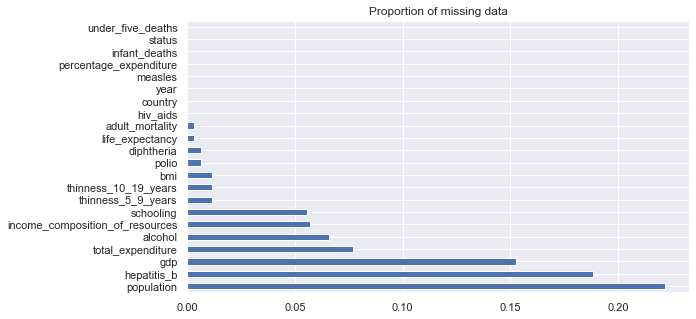

In [395]:
missing_data_cols = (df_clean.isnull().sum()/len(df_clean)).sort_values(ascending = False)
missing_data_cols.plot(kind = 'barh',figsize = (9,5))
plt.title('Proportion of missing data');

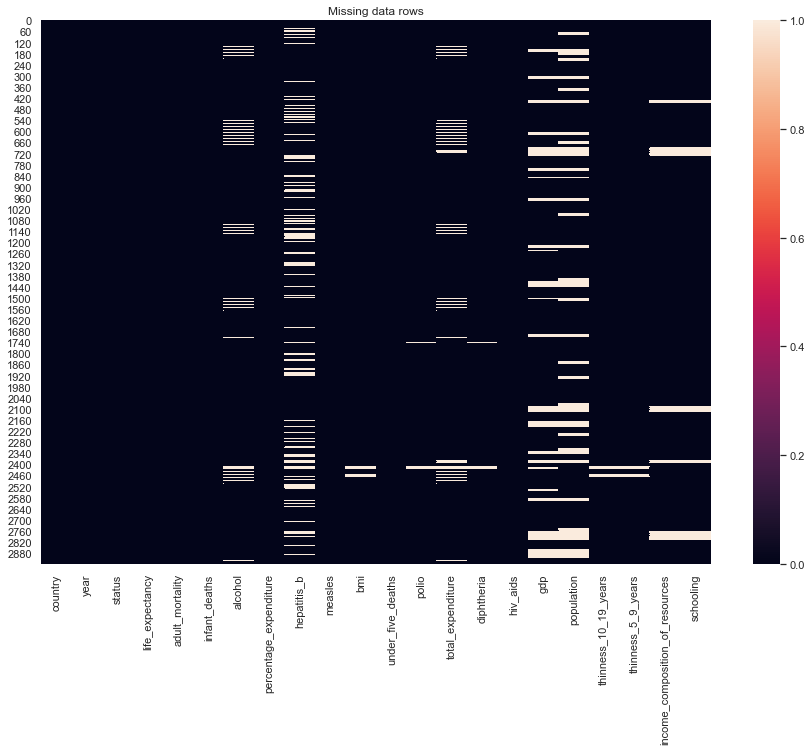

In [396]:
plt.figure(figsize = (15,10))
sns.heatmap(df_clean.isnull())
plt.title('Missing data rows');

In [397]:
#total missing values
df_clean.isnull().sum().sum()

2563

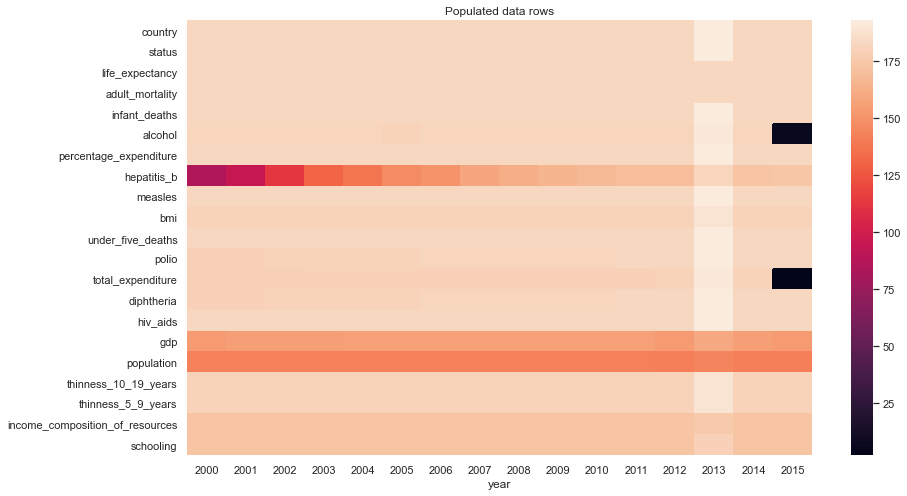

In [398]:
plt.figure(figsize = (14,8))
sns.heatmap(df_clean.groupby('year').count().transpose())
plt.title('Populated data rows');

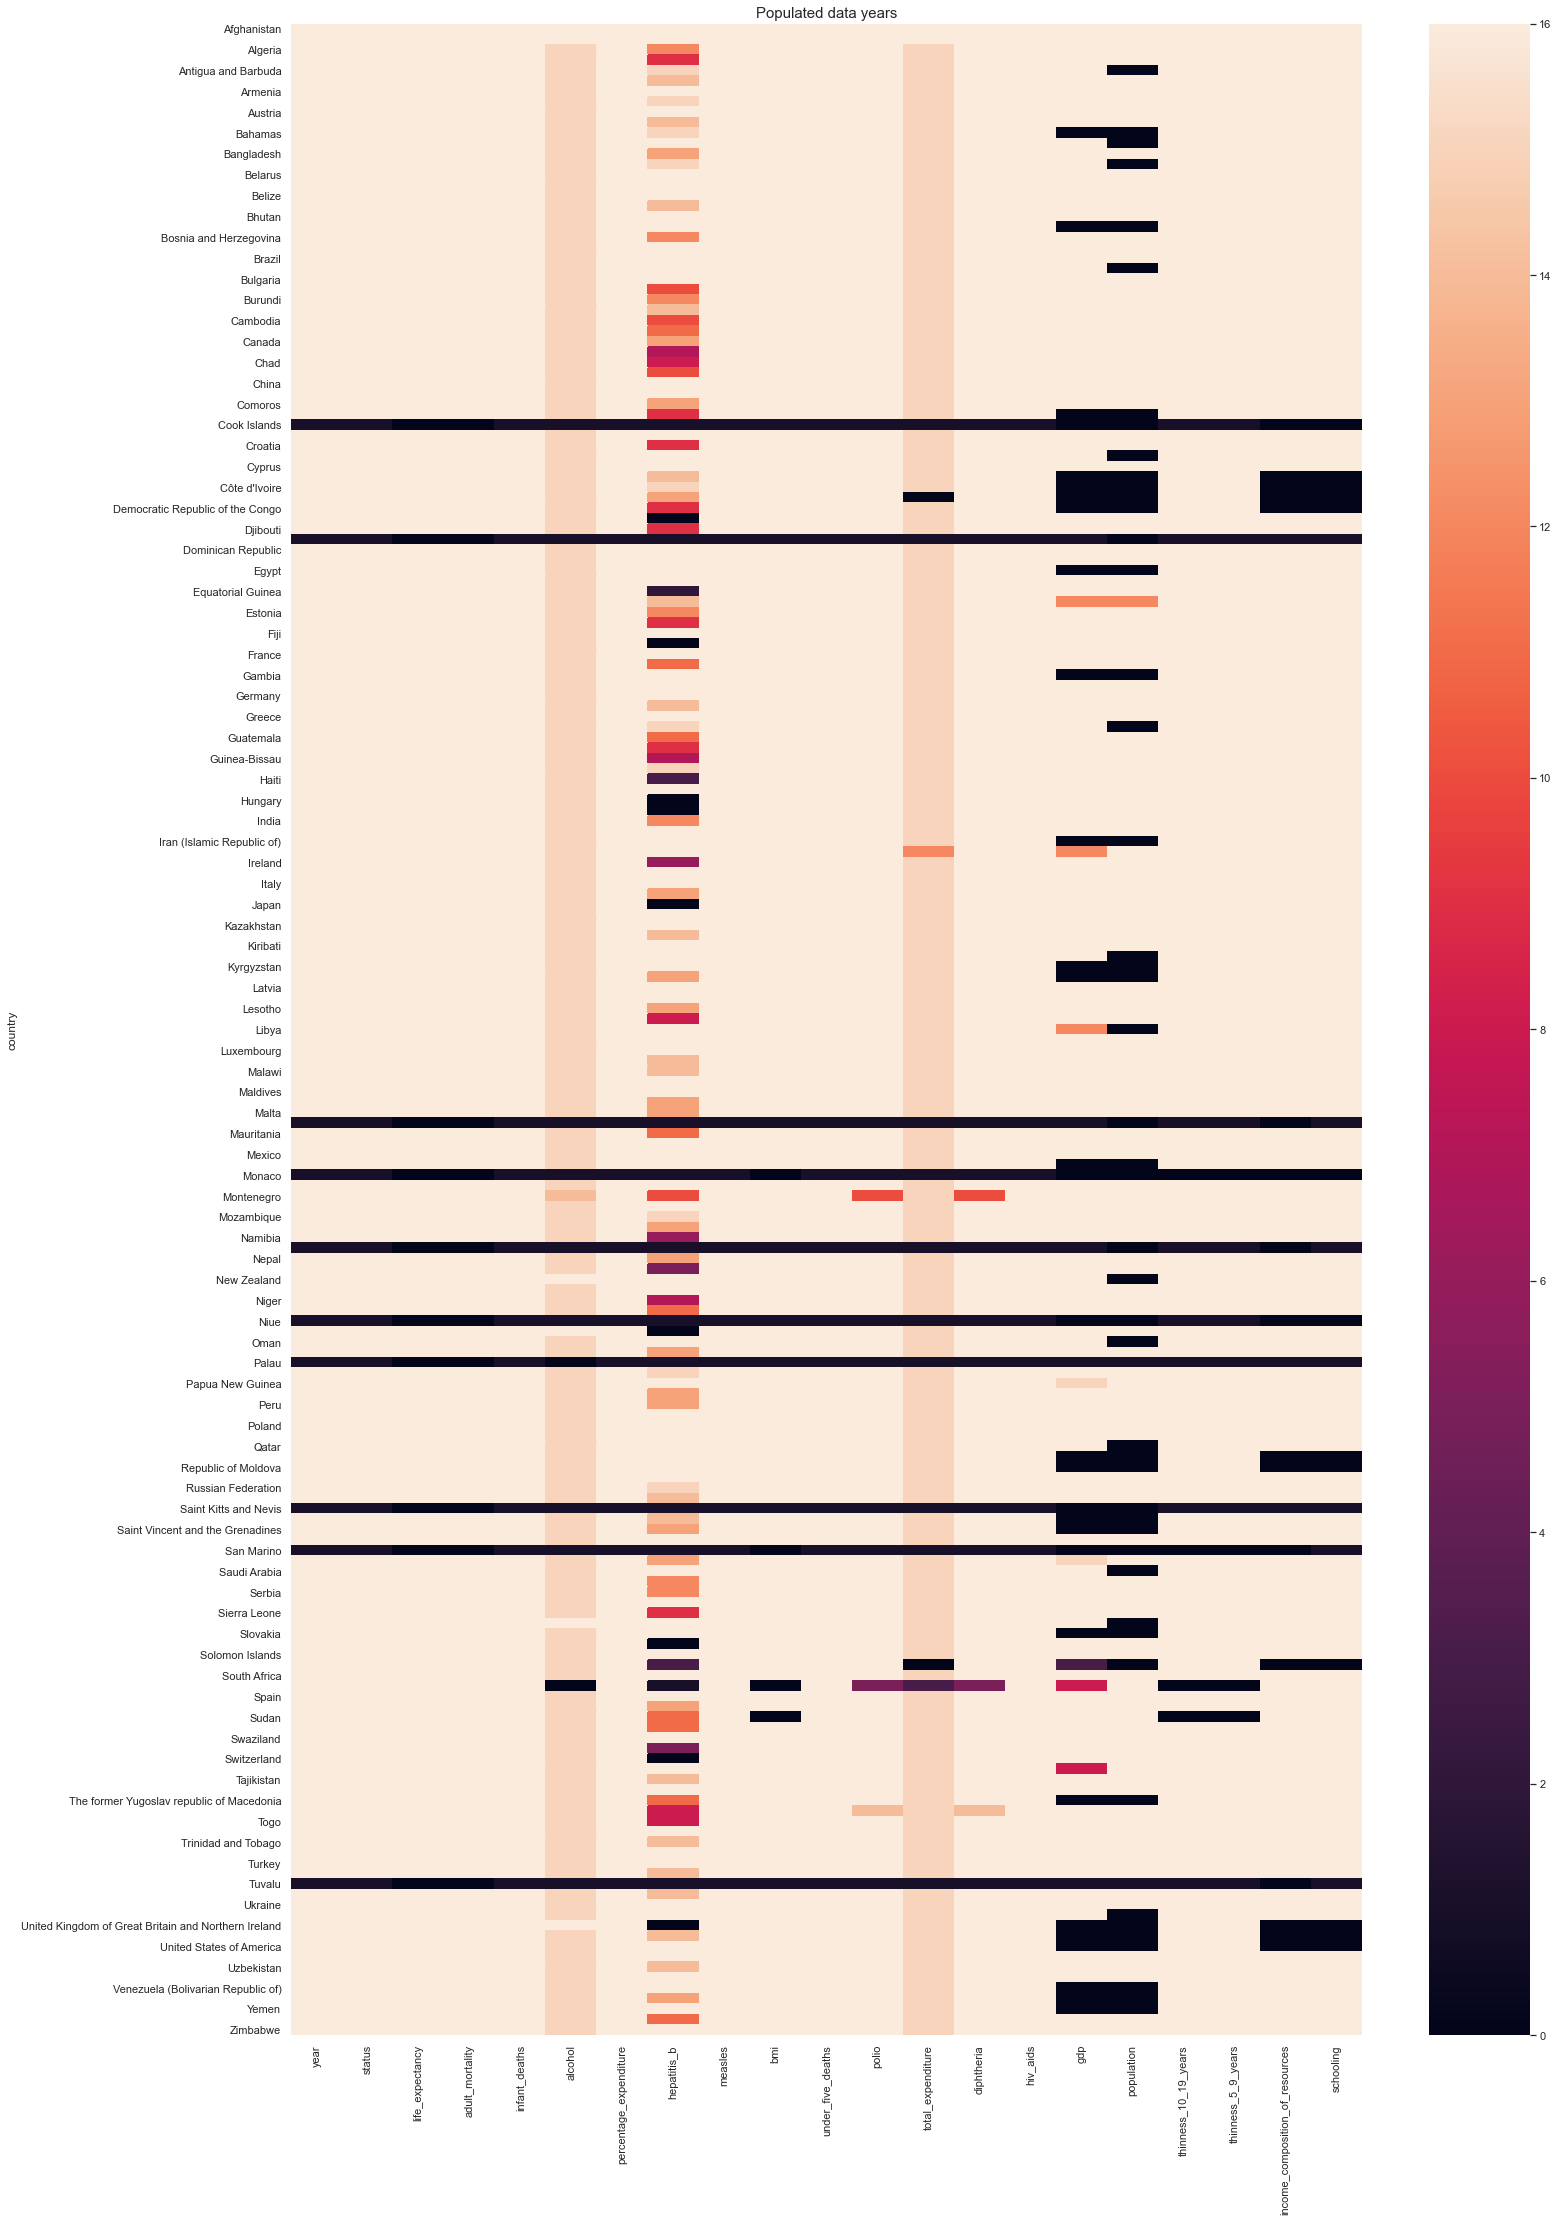

In [399]:
plt.figure(figsize = (24,37))
sns.heatmap(df_clean.groupby('country').count())
plt.title('Populated data years', size = 15);

- Good amount of gdp, hepatitis_b and population data missing. This is consistent across years.
- 2015 hardly populated in alcohol and total expenditure variables.
- Various countries missing data for all years

In [400]:
def plot_missing_data(df,var, by,figsize = (10,10)):
    """
    This function plots a heatmap of missing data in a given column by another specified variable.
    It can be used to understand the distributions of missing data better.
    """
    plt.figure(figsize = figsize)
    df = pd.DataFrame(df[var].isnull().groupby(df[by]).sum().sort_values())
    mask = df[var] > 0
    sns.heatmap(df[mask],annot = True,cmap='rocket_r')

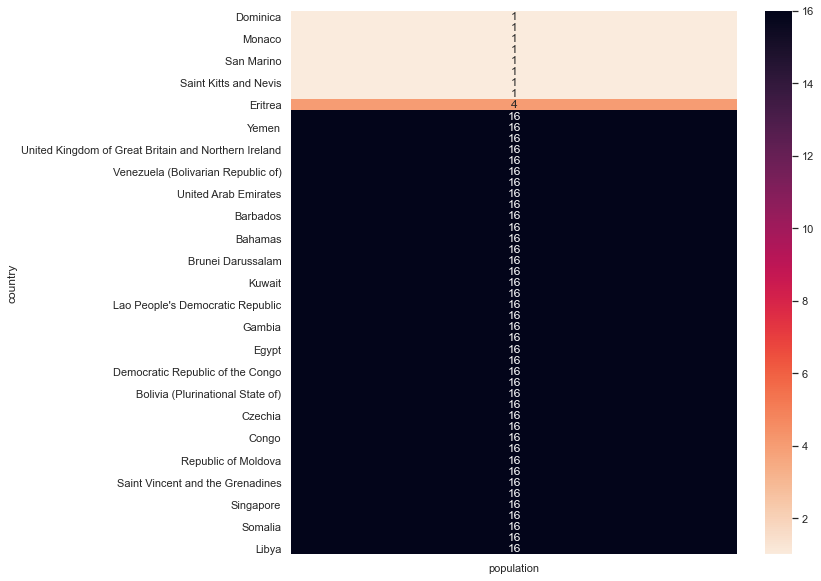

In [401]:
plot_missing_data(df_clean,'population','country')

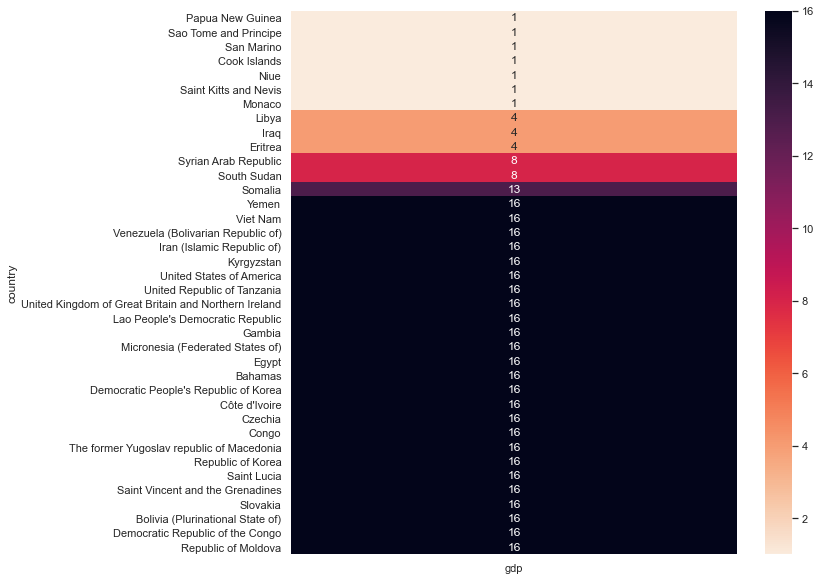

In [402]:
plot_missing_data(df_clean,'gdp','country')

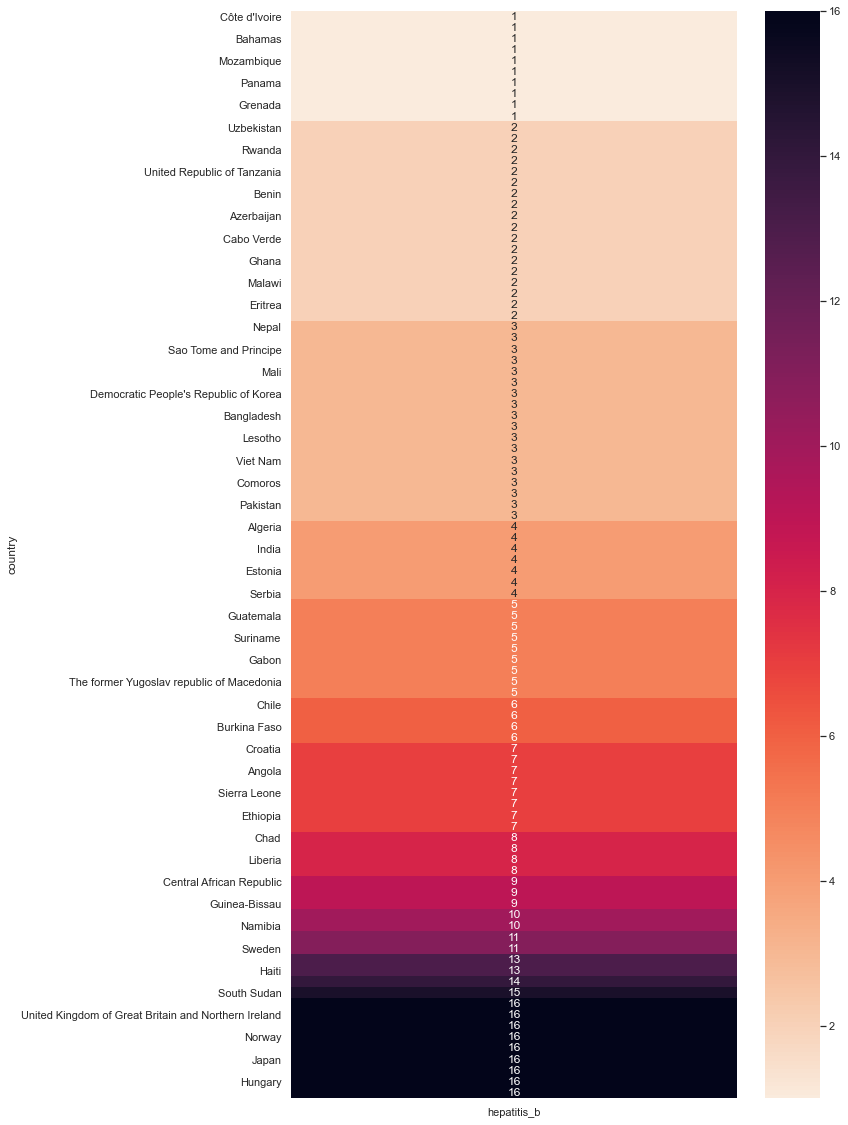

In [403]:
plot_missing_data(df_clean,'hepatitis_b','country', figsize = (10,20))

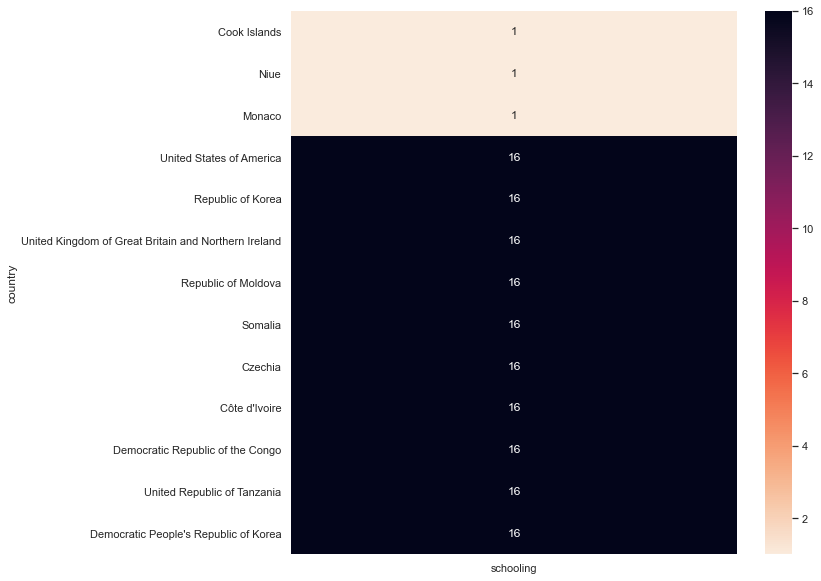

In [404]:
plot_missing_data(df_clean,'schooling','country')

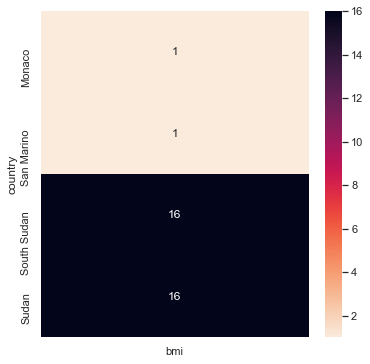

In [405]:
plot_missing_data(df_clean,'bmi','country', figsize = (6,6))

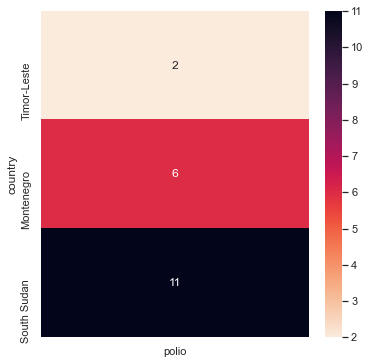

In [406]:
plot_missing_data(df_clean,'polio','country', figsize = (6,6))

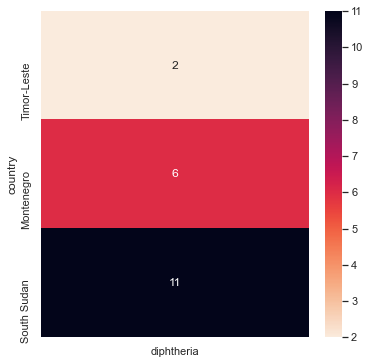

In [407]:
plot_missing_data(df_clean,'diphtheria','country',figsize = (6,6))

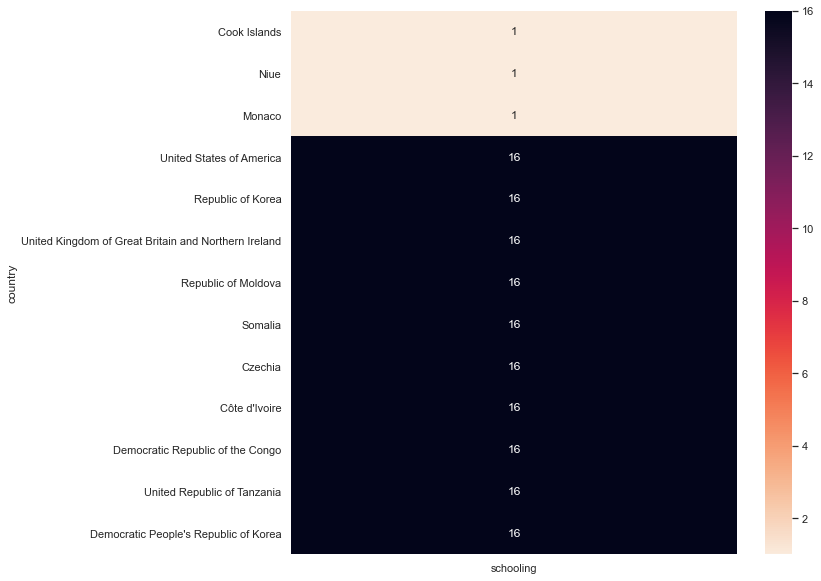

In [408]:
plot_missing_data(df_clean,'schooling','country')

#### Comment
- There are a wide spread of countries missing GDP and population data for all years.
- For hepatitis b, there is more of a spread with fewer countries missing all years of data. However, there is no observable country trend to indicate some countries are more likely than others to be missing this data.


__To Do__
- Handle missing data.

### Univariate Exploration

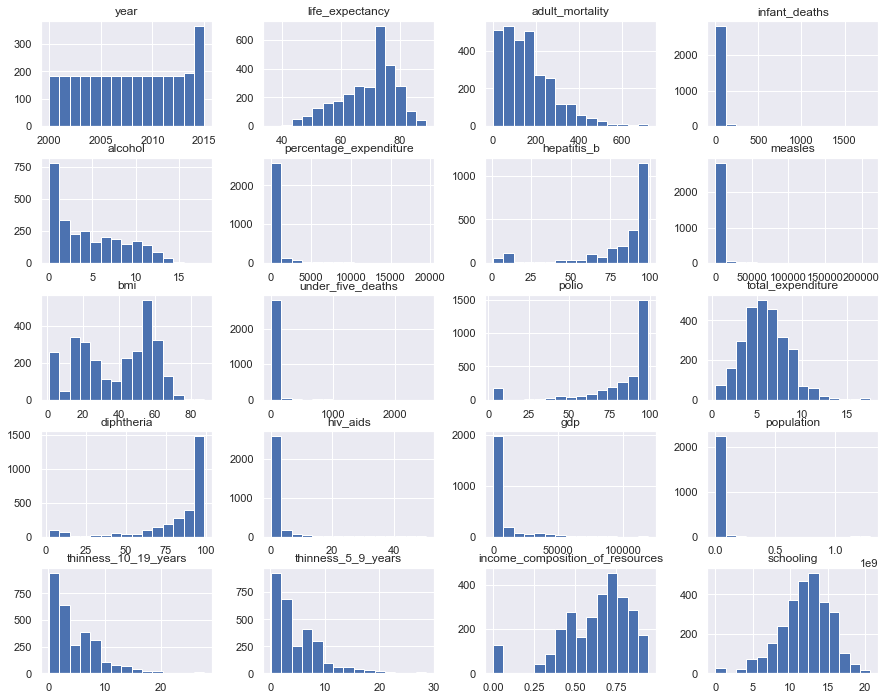

In [409]:
df_clean.hist(bins = 15, figsize = (15,12));

- All disease related distributions are highly skewed.
- Schooling and total expenditure look fairly normally distributed.
- BMI has a nearly bimodal distribution.

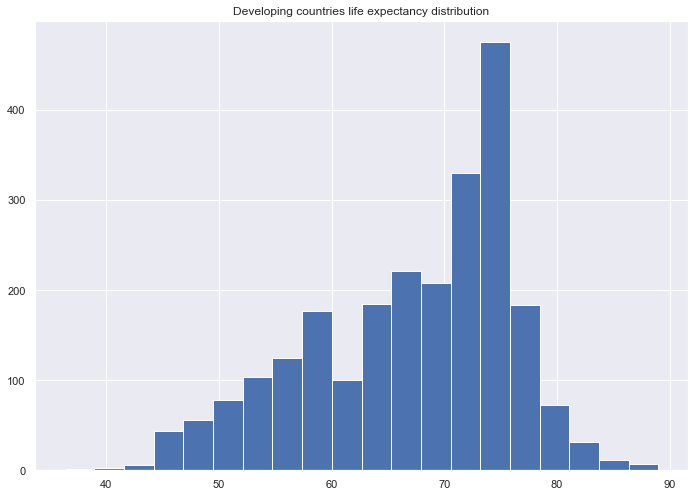

In [410]:
plt.hist(x='life_expectancy', data = df_clean.query('status == "Developing"'),bins = 20)
plt.title('Developing countries life expectancy distribution');

- There are some developing countries with very high life expectancies.
- Left skewed distribution

In [411]:
df_clean.query('status =="Developing"').groupby('country')['life_expectancy'].mean().sort_values(ascending = False).head(20)

country
France                   82.21875
Canada                   81.68750
Israel                   81.30000
Greece                   81.21875
Finland                  80.71250
Republic of Korea        80.48750
Chile                    79.45000
Costa Rica               78.59375
Cuba                     77.97500
Qatar                    77.03125
Brunei Darussalam        76.48750
Panama                   76.48750
Uruguay                  76.07500
Bosnia and Herzegovina   75.96875
Bahrain                  75.72500
Mexico                   75.71875
United Arab Emirates     75.70000
Maldives                 75.53750
Albania                  75.15625
Argentina                75.15625
Name: life_expectancy, dtype: float64

In [412]:
df_clean.query('status =="Developed"').groupby('country')['life_expectancy'].mean().sort_values(ascending = False).head(15)

country
Japan                                                  82.53750
Sweden                                                 82.51875
Iceland                                                82.44375
Switzerland                                            82.33125
Italy                                                  82.18750
Spain                                                  82.06875
Australia                                              81.81250
Norway                                                 81.79375
Austria                                                81.48125
Singapore                                              81.47500
New Zealand                                            81.33750
Germany                                                81.17500
Netherlands                                            81.13125
United Kingdom of Great Britain and Northern Ireland   80.79375
Luxembourg                                             80.78125
Name: life_expectancy, dtype: fl

- Canada, France and Israel are developed countries.
- For the remaining top-ranked developing countries by life_expectancy, some might be considered as developed.
- However, given that their inclusion debateable, I will leave them as Developing (e.g. Greece).

In [413]:
#reassign developed status labels
countries_to_change = ['France','Canada','Israel']
df_clean.loc[df_clean.country.isin(countries_to_change),'status'] = 'Developed'

In [414]:
df_clean.query('status =="Developing"').groupby('country')['life_expectancy'].mean().sort_values(ascending = False).head(10)

country
Greece              81.21875
Finland             80.71250
Republic of Korea   80.48750
Chile               79.45000
Costa Rica          78.59375
Cuba                77.97500
Qatar               77.03125
Brunei Darussalam   76.48750
Panama              76.48750
Uruguay             76.07500
Name: life_expectancy, dtype: float64

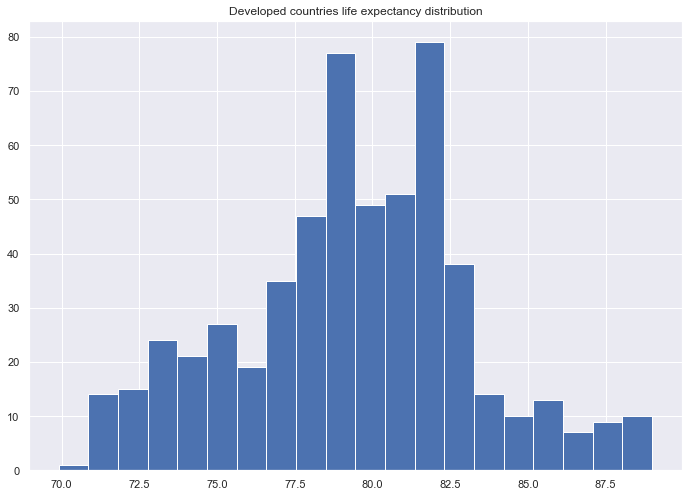

In [415]:
plt.hist(x='life_expectancy', data = df_clean.query('status == "Developed"'),bins = 20)
plt.title('Developed countries life expectancy distribution');

- Distribution is as expected.

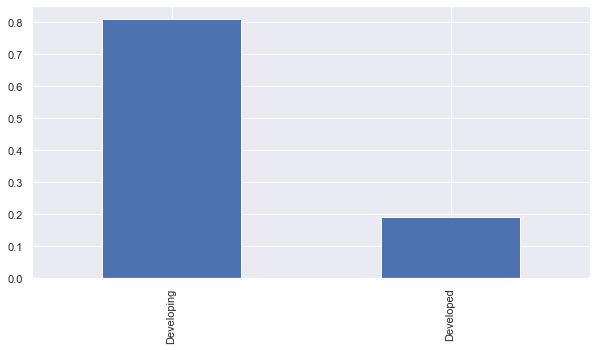

In [416]:
(df_clean.status.value_counts()/len(df_clean)).plot(kind = 'bar',figsize = (10,5));

- Many more countries classified as developing, as expected.

### Bivariate Exploration

#### Questions: 
- Which variables are strongly correlated to life expectancy?
- How do these vary with a country's status i.e. developed vs developing?

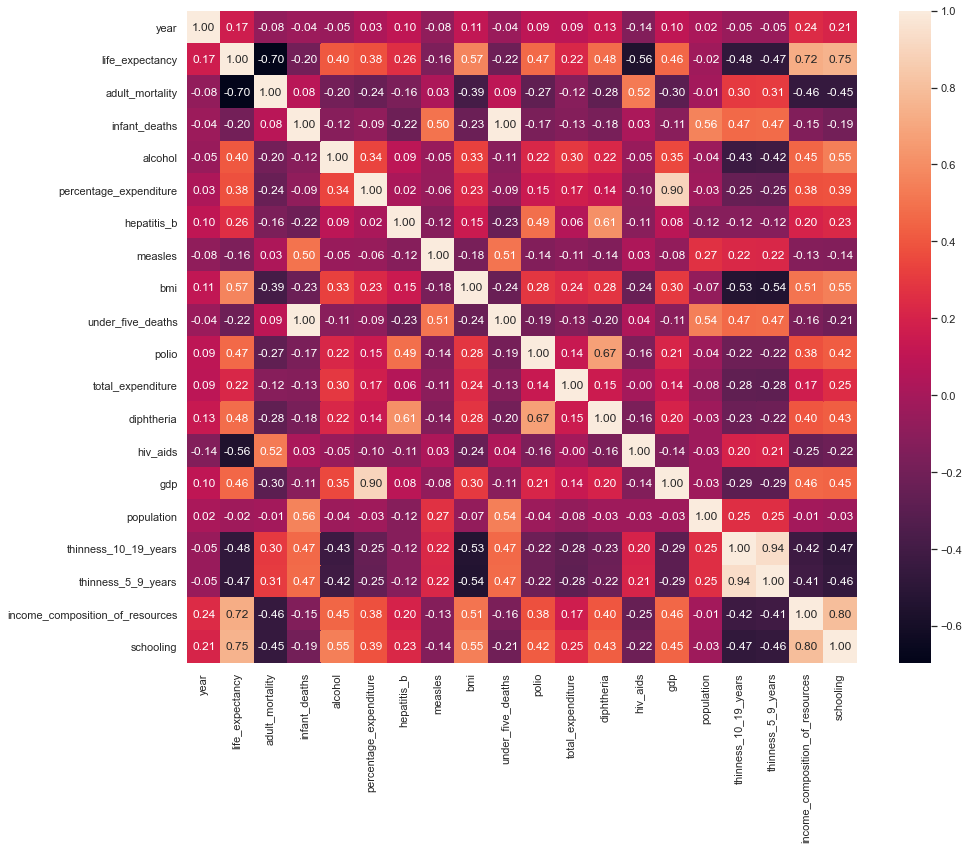

In [417]:
plt.figure(figsize = (15,12))
sns.heatmap(df_clean.corr(),annot=True,fmt='.2f');

- Income composition of resources and schooling have the highest correlation with life expectancy.
- Thinness, hiv/aids and adult mortality have a strong negative correlation with life expectancy.

<AxesSubplot:xlabel='None-status', ylabel='variable'>

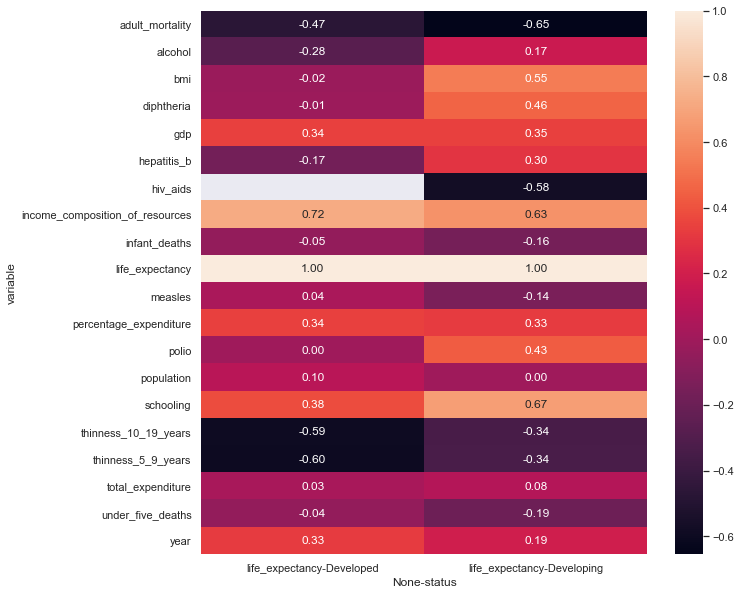

In [418]:
le_corrs = df_clean.groupby('status').corr().loc[:,'life_expectancy'].reset_index()
le_corrs.rename(columns = {'level_1':'variable'},inplace=True)
fig,ax = plt.subplots(figsize = (10,10))
sns.heatmap(le_corrs.pivot(columns = 'status',index='variable'),annot=True,fmt = '.2f')

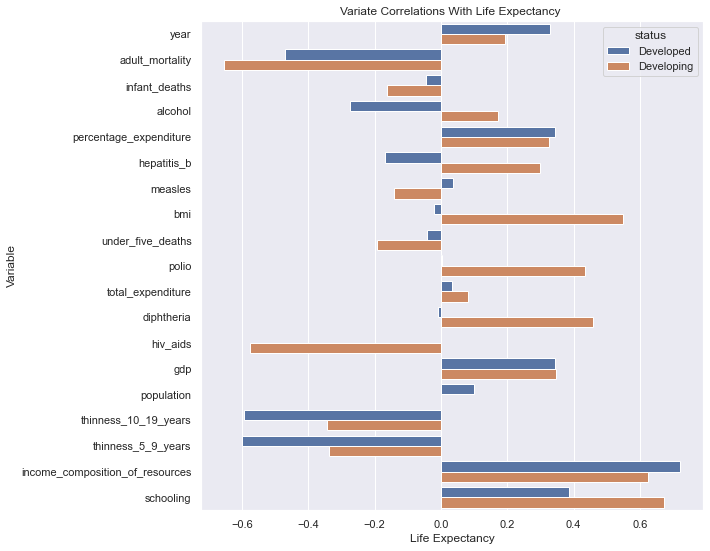

In [419]:
fig,ax = plt.subplots(figsize = (9,9))
sns.barplot(data = le_corrs.query('variable != "life_expectancy"'),
            y = 'variable', x = 'life_expectancy',hue = 'status')
plt.ylabel('Variable')
plt.xlabel('Life Expectancy')
plt.title('Variate Correlations With Life Expectancy ');

- HIV/AIDS has no correlation to life expectancy in developed countries, but is highly correlated to life expectancy in developing countries.
- Thinness amongst adolescents may a more important factor in developed countries in determining life expectancy.
- Schooling is more strongly correlated to life expectancy in developing countries.
- All diseases have stronger correlations to life expectancy in developing countries.

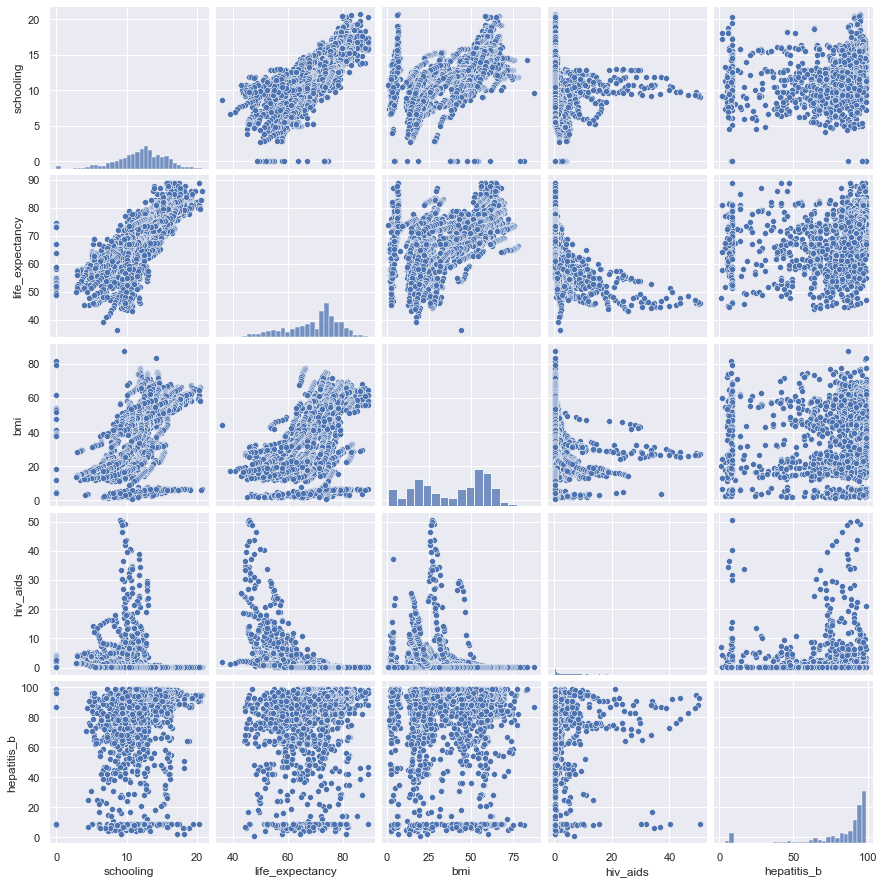

In [420]:
cols = ['schooling','life_expectancy','bmi','hiv_aids','hepatitis_b']
sns.pairplot(df_clean.loc[:,cols]);

- Schooling shows very high correlation to life expectancy.
- BMI strong correlation to life expectancy. Is this because richer, better developed countries have higher BMIs?

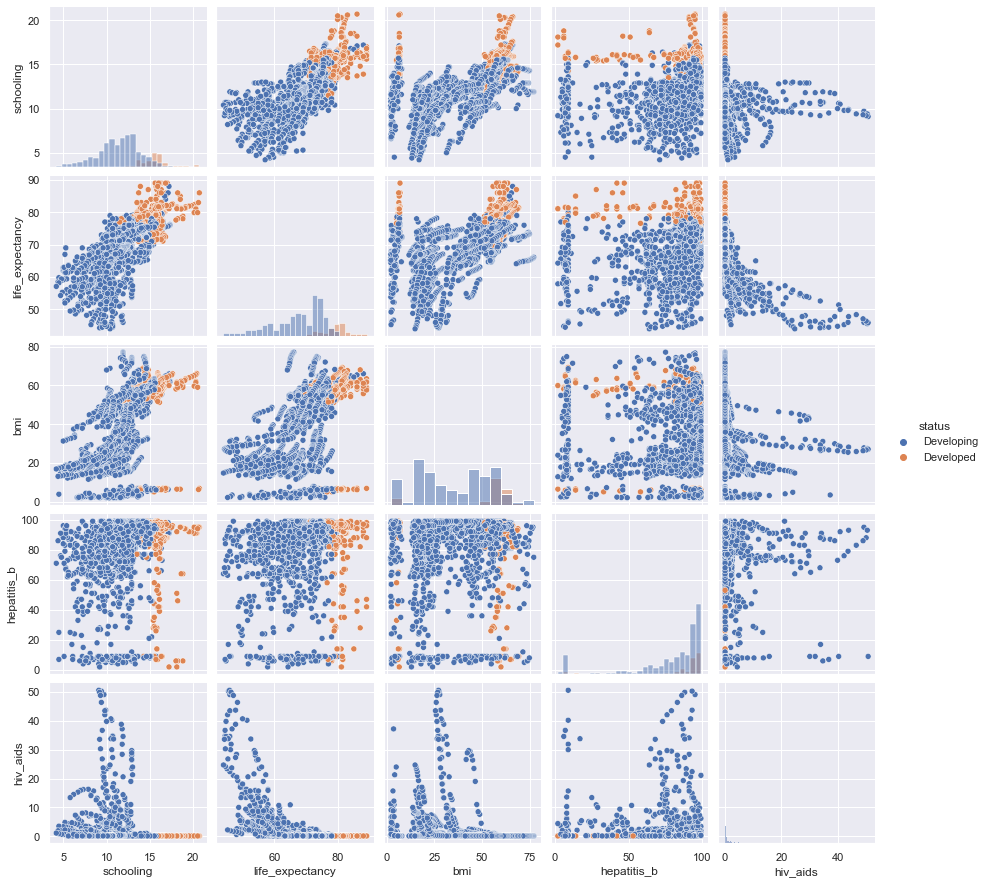

In [421]:
cols = ['schooling','life_expectancy','bmi','status','hepatitis_b','hiv_aids']
sns.pairplot(df_clean.dropna().loc[:,cols],hue='status',diag_kind = 'hist');

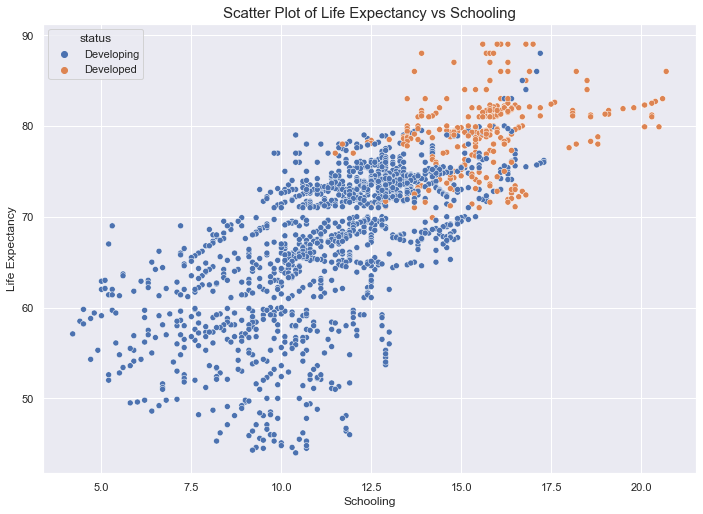

In [537]:
sns.scatterplot(x='schooling',y='life_expectancy',data = df_clean, hue = 'status')
plt.title('Scatter Plot of Life Expectancy vs Schooling', size = 15)
plt.xlabel('Schooling')
plt.ylabel('Life Expectancy');

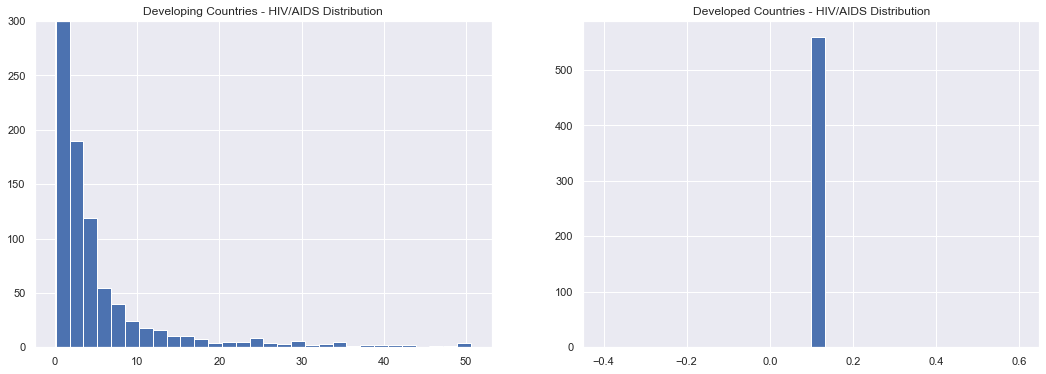

In [423]:
plt.figure(figsize = (18,6))

plt.subplot(1,2,1)
mask = (df_clean.status == 'Developing')
plt.hist(df_clean[mask]['hiv_aids'],label = 'Developing',bins = 30)
plt.title('Developing Countries - HIV/AIDS Distribution')
plt.ylim(0,300)

plt.subplot(1,2,2)
mask = (df_clean.status == 'Developed')
plt.hist(df_clean[mask]['hiv_aids'],label = 'Developed',bins = 30)
plt.title('Developed Countries - HIV/AIDS Distribution');

- Developed countries have a higher bmi on average than developing countries.
- The bimodal distribution implies there may be countries listed as developing who may have characteristics very close to that of developed countries.
- The data indicates there is hardly any HIV/AIDS prevalence in developed countries.
- HIV/AIDS appears to only be a problem for developing countries.

#### Question
- How have variable distributions changed over time for developing and developed countries?

In [424]:
test = df_clean[['life_expectancy', 'year','status','country']]
test = test.pivot(values='life_expectancy',columns ='status',index = ['year','country'])
test = test.reset_index()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        2938 non-null   int64  
 1   country     2938 non-null   object 
 2   Developed   560 non-null    float64
 3   Developing  2368 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 91.9+ KB


<Figure size 842.4x595.44 with 0 Axes>

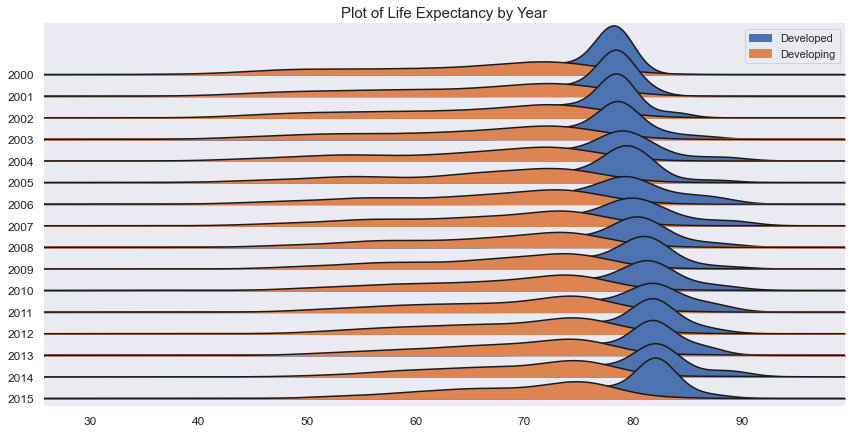

In [425]:
df_clean_joy = df_clean[['life_expectancy', 'year','status','country']]
df_clean_joy = df_clean_joy.pivot(values='life_expectancy',columns ='status',index = ['year','country']).reset_index()

plt.figure()

joyplot(
    data=df_clean_joy,
    by = 'year',
    figsize=(12, 6),
    legend = True
)
plt.title('Plot of Life Expectancy by Year', fontsize=15);

- The difference in life expectancy distributions are not large on this type of chart.

In [426]:
import cmasher as cmr

def plot_kde_reg(df, var, status, start=2000, stop=2016, step=4, figsize = (22,6)):
    """
    This function plots kde and regression scatter charts of a given variable from a specified dataframe.
    You can use the start, stop and step parameters based on the chart granularity you want to see on the kde chart.
    """
    #set colour palette
    
    colours = cmr.take_cmap_colors('viridis_r', 6, return_fmt='hex')[1:]
    
    #initialise plots
    fig, ax = plt.subplots(ncols=2,figsize = figsize)
    
    #plot developed countries chart
    for i,yr in enumerate(range(start,stop,step)):
        mask = (df.year == yr) & (df.status == status)
        sns.kdeplot(df[mask][var],label = yr,ax=ax[0],color=colours[i])
    ax[0].legend()
    
    #plot regression countries chart
    base_colour = sns.color_palette()[0]
    mask = (df_clean.status == status)
    sns.regplot(x = 'year',y = var, data = df_clean[mask],label = yr,
                color=base_colour,scatter_kws={'alpha':0.5},ax=ax[1])
    
    #set figure title
    varname = var.replace('_',' ').title()
    plt.suptitle(f'{status} Countries - {varname} Distribution', size = 15)

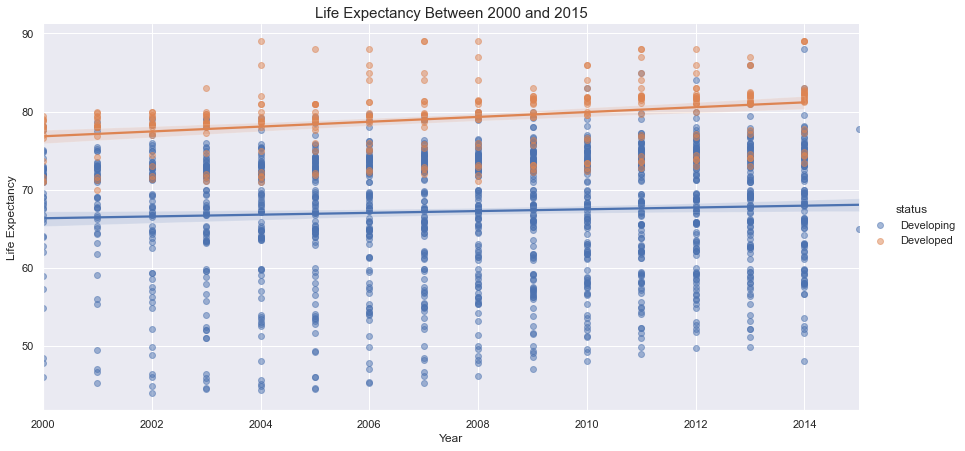

In [535]:
sns.lmplot(x = 'year',y = 'life_expectancy', data = df_clean,hue = 'status',scatter_kws= {'alpha':0.5},
          height=6,aspect=2)
plt.title('Life Expectancy Between 2000 and 2015',size = 15)
plt.ylabel('Life Expectancy')
plt.xlabel('Year');

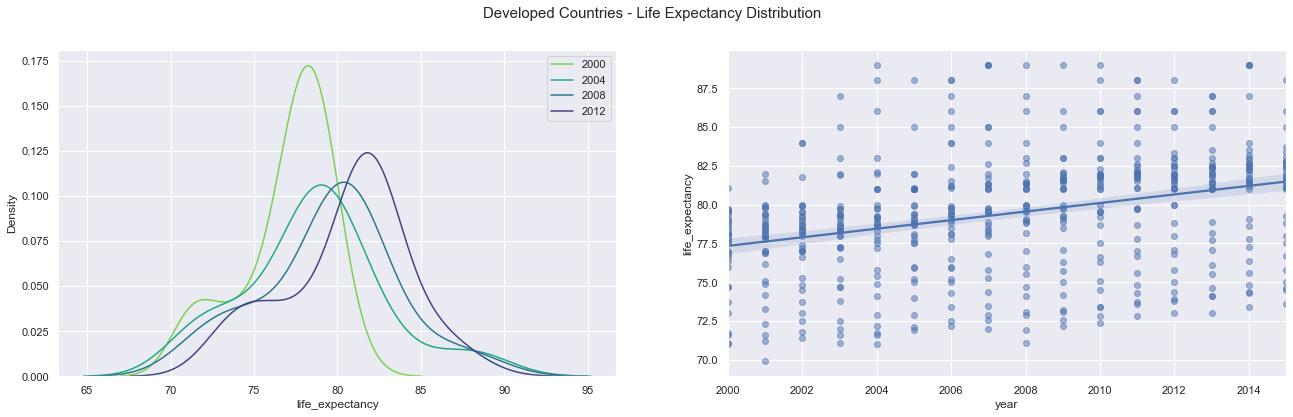

In [428]:
plot_kde_reg(df_clean,'life_expectancy','Developed')

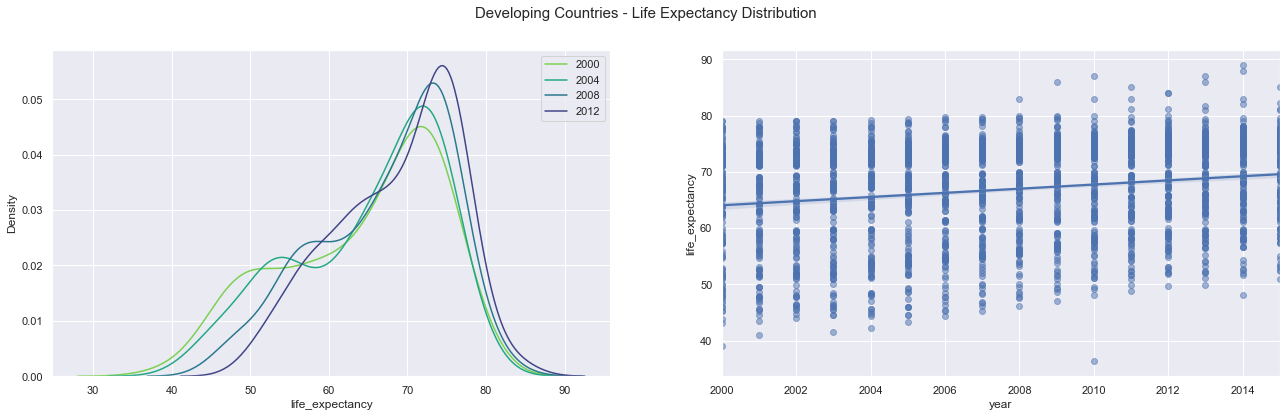

In [429]:
plot_kde_reg(df_clean,'life_expectancy','Developing')

In [430]:
le_inc = df_clean.groupby(['status','year'])['life_expectancy'].mean()
print('Developed improvement:',le_inc.loc[('Developed',2015)]-le_inc.loc[('Developed',2000)])
print('Developing improvement:',le_inc.loc[('Developing',2015)]-le_inc.loc[('Developing',2000)])

Developed improvement: 3.86571428571429
Developing improvement: 5.103378378378309


- Average life expectancies have improved over time for both developing and developed countries.
- There has been more improvement for developed countries, even though they started the period from a higher level.

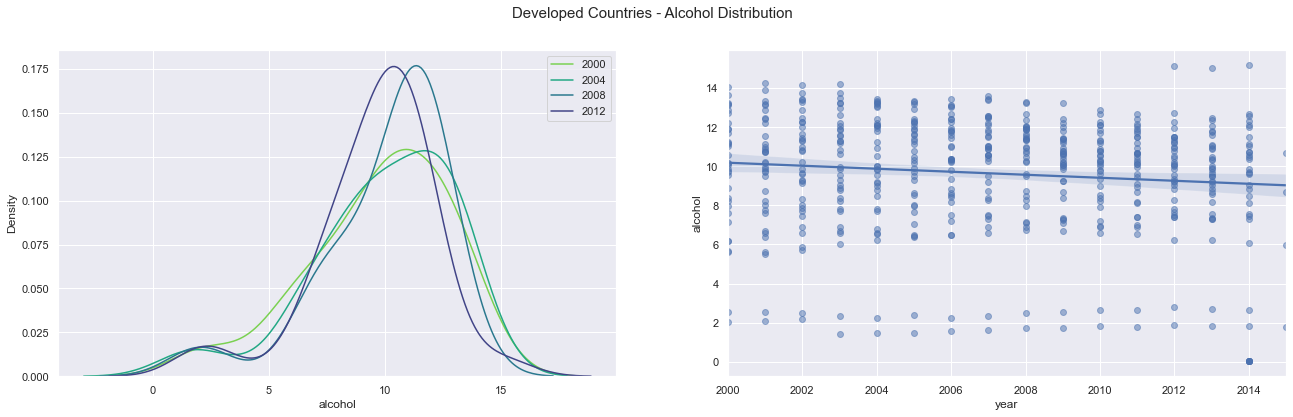

In [431]:
plot_kde_reg(df_clean,'alcohol','Developed')

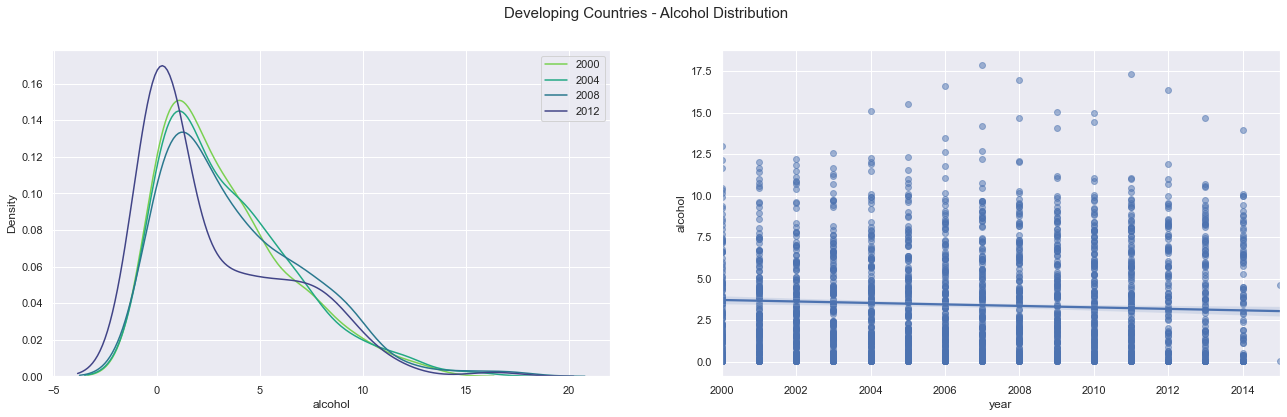

In [432]:
plot_kde_reg(df_clean,'alcohol','Developing')

- All countries are drinking less on average.

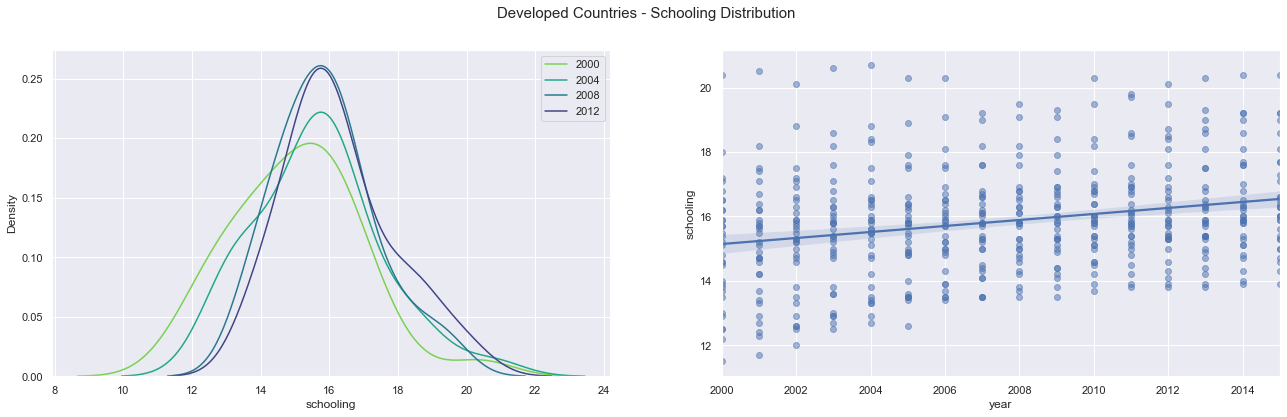

In [433]:
plot_kde_reg(df_clean,'schooling', 'Developed')

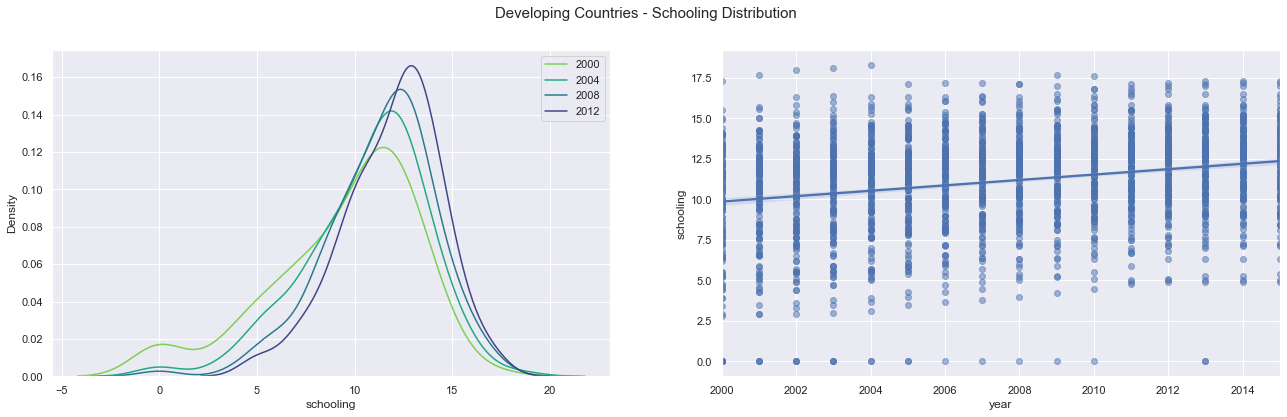

In [434]:
plot_kde_reg(df_clean,'schooling', 'Developing')

- Average schooling has improved over time for both developed and developing countries.

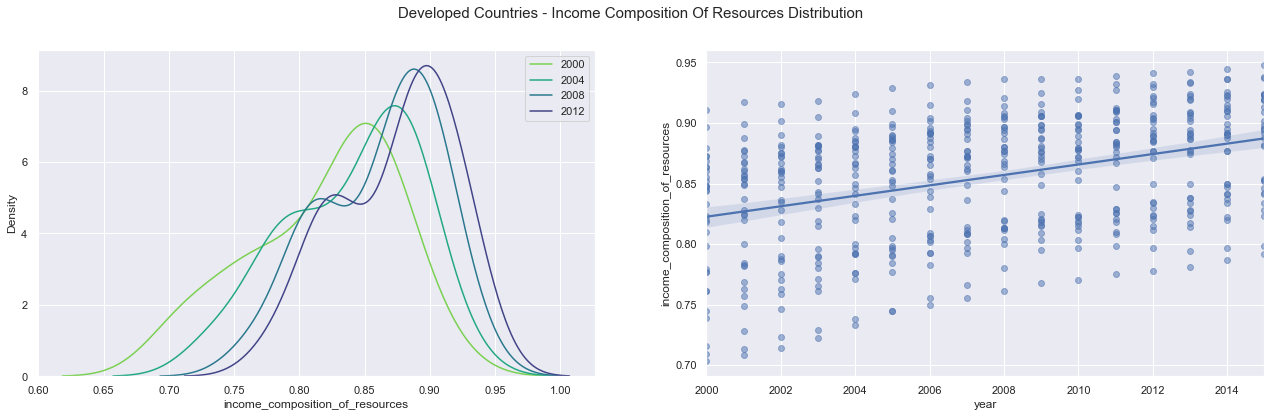

In [435]:
plot_kde_reg(df_clean,'income_composition_of_resources','Developed')

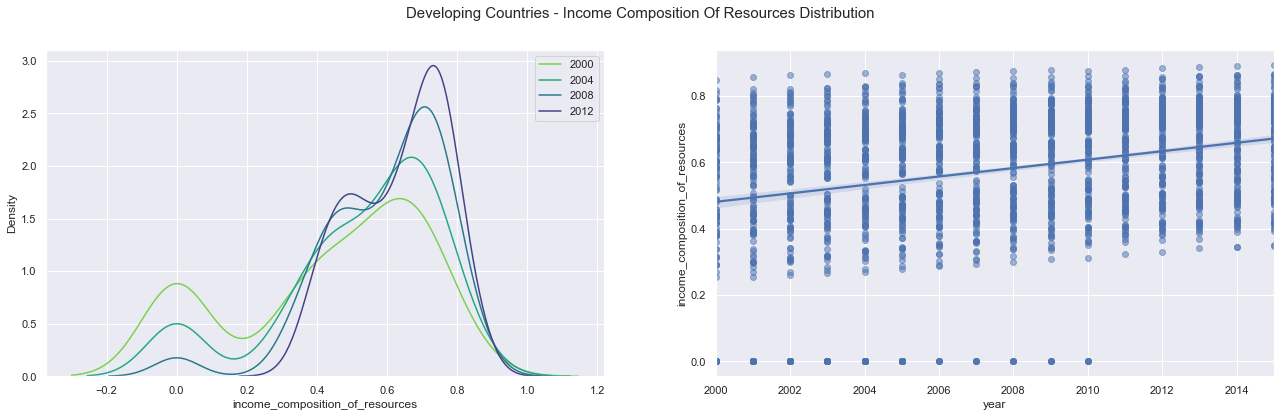

In [436]:
plot_kde_reg(df_clean,'income_composition_of_resources','Developing')

- Wikipedia definition of this variable: 
   - The Human Development Index (HDI) is a statistic composite index of life expectancy, education (mean years of schooling completed and expected years of schooling upon entering the education system), and per capita income indicators, which is used to rank countries into four tiers of human development.
   
- This should be removed as part of the data is formed from life expectancy data.


- Both developed and developing countries have seen positive improvements over time.

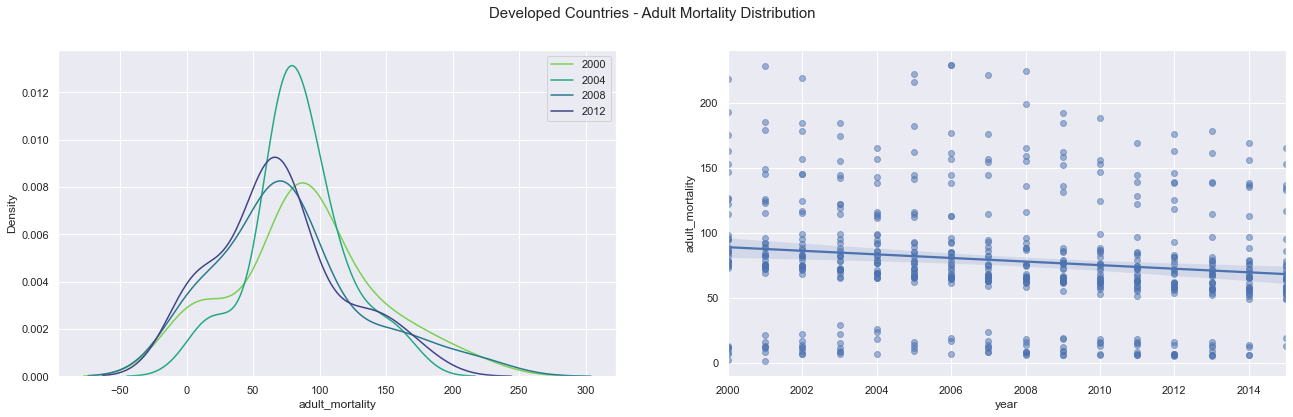

In [437]:
plot_kde_reg(df_clean,'adult_mortality','Developed')

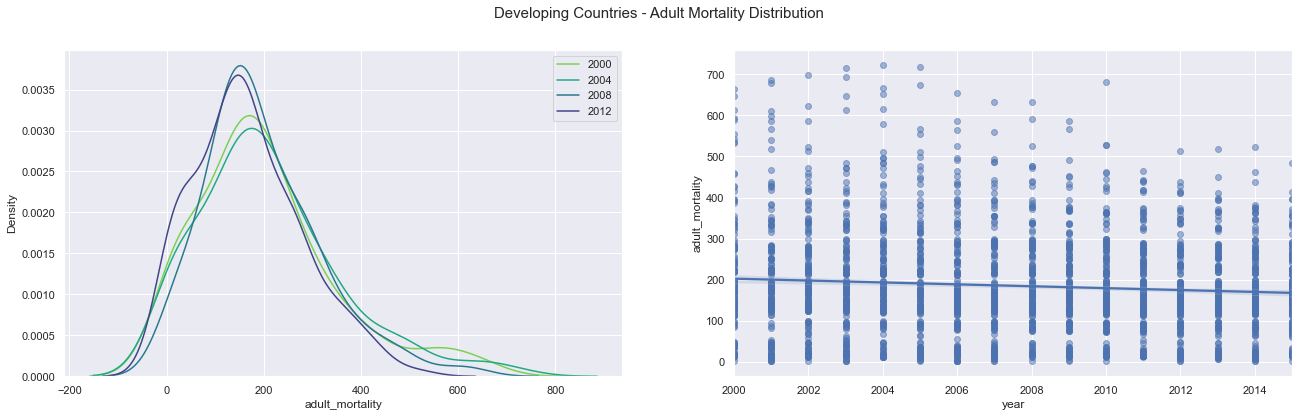

In [438]:
plot_kde_reg(df_clean,'adult_mortality','Developing')

- Do not use this variable in analysis / prediction. We want to use socioeconomic variables for this.
- Both developing or developed countries have seen a reduction in adult mortality over time.

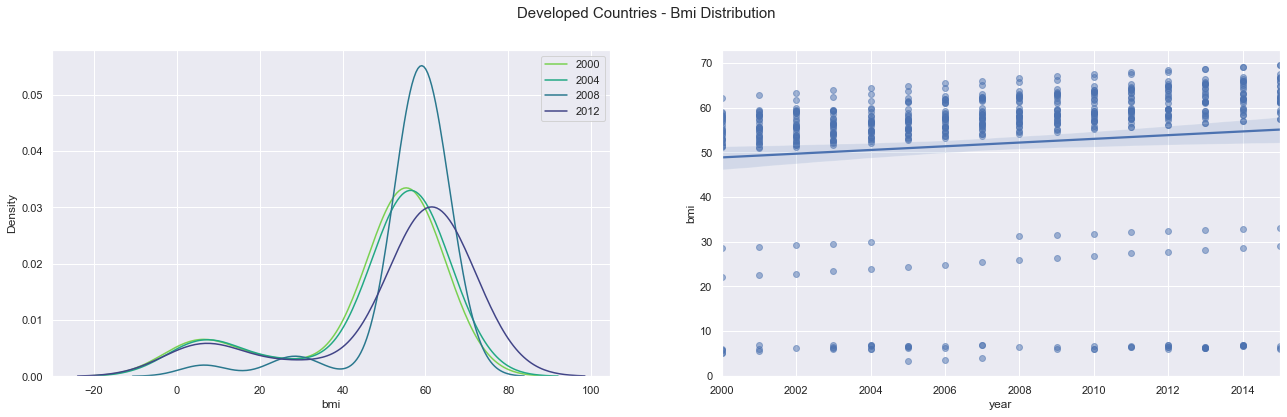

In [439]:
plot_kde_reg(df_clean,'bmi','Developed')

In [440]:
df_clean.query('status == "Developed"').sort_values(by='bmi').loc[:,['country','year','bmi']].head(10)

country  year     bmi
2323    Singapore  2005 3.20000
2322    Singapore  2006 3.50000
2321    Singapore  2007 3.90000
143       Austria  2000 5.10000
2070     Portugal  2000 5.10000
142       Austria  2001 5.60000
2344     Slovakia  2000 5.70000
2536  Switzerland  2000 5.80000
2069     Portugal  2001 5.90000
1527    Lithuania  2010 6.00000

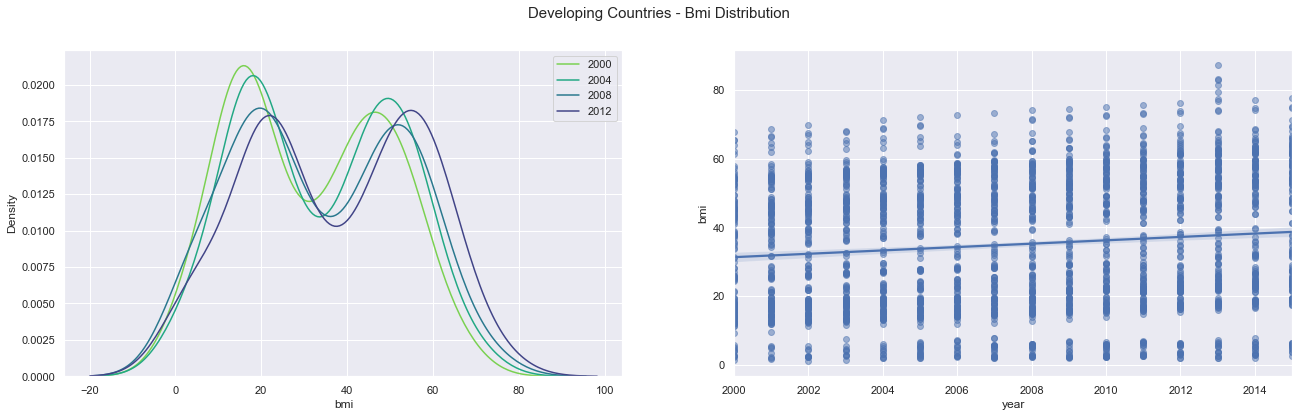

In [441]:
plot_kde_reg(df_clean,'bmi','Developing')

- Developing countries have a bimodal distribution
- BMIs in both types of country are increasing.
- There are some wrong looking values. BMIs should not be much less than 15-20.
- Equally, the distributions looks high at the top end of the range.
- I am not going to clean these. However, this column is less useful as a result.

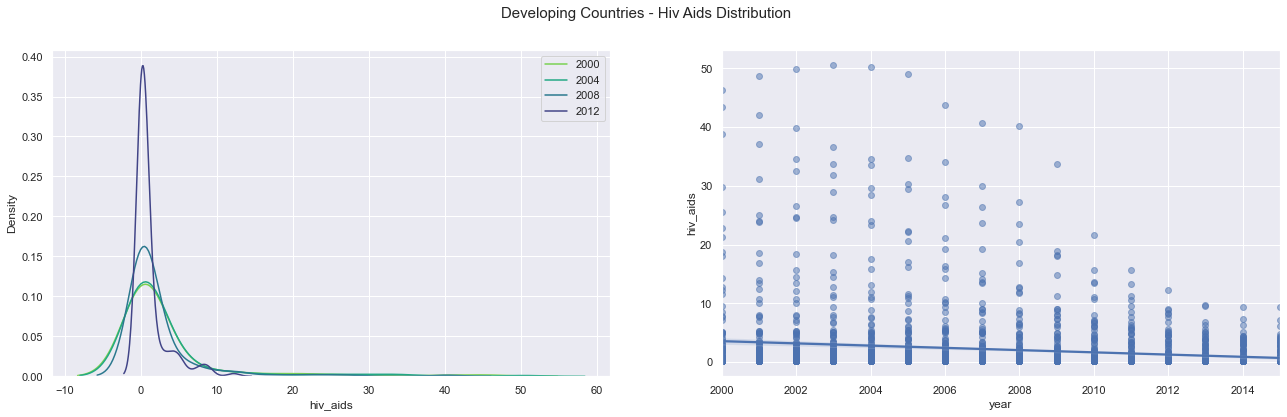

In [442]:
plot_kde_reg(df_clean,'hiv_aids',status = 'Developing')

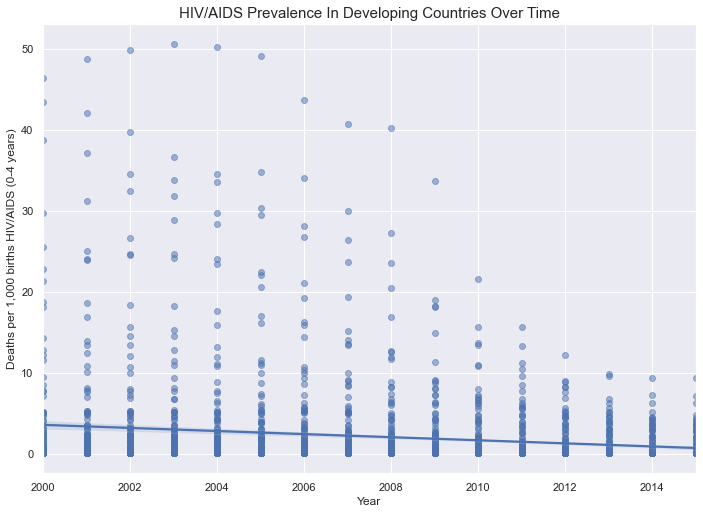

In [443]:
base_colour = sns.color_palette()[0]
mask = (df_clean.status == 'Developing')
sns.regplot(x = 'year',y = 'hiv_aids', data = df_clean[mask],color=base_colour,scatter_kws={'alpha':0.5})
plt.title('HIV/AIDS Prevalence In Developing Countries Over Time', size = 15)
plt.xlabel('Year')
plt.ylabel('Deaths per 1,000 births HIV/AIDS (0-4 years)');

- Distribution has become more concentrated over time i.e. extreme HIV/AIDS prevalence has reduced over time

### Missing Data Cleaning

- I'm going to impute the missing numeric variable values where possible, by filling a given year with the average of the prior 3 years of data.
- This seems a reasonable approach, given we wouldn't expect huge changes from these numeric variables from year to year.
- Any remaining missing data rows, I will remove.

In [444]:
def fill_na(df, cols,min_periods = 1, window =3):
    """
    This function takes a list of column names within a dataframe and fills nan values with the mean 
    of a specified number of prior rows, grouped by country and year.
    e.g. if Zimbabwe has a missing GDP value in 2015, using the default values,
    this function will fill it with the average of GDP values from 2012-2014
    """
    #fill columns with average of prior 3 row values grouped by country and year
    start_nulls = df.isnull().sum()
    for col in cols:
        print(col)
        fill_vals = df.groupby(['country','year'])[col].mean().reset_index()
        fill_vals = fill_vals.rolling(min_periods = min_periods, window = window,on='year').mean()[col]
        df[col] = df[col].fillna(fill_vals)
    
    end_nulls = df.isnull().sum()
    cleaned_nulls = start_nulls - end_nulls
    return df, cleaned_nulls

In [445]:
cols = missing_data_cols[missing_data_cols>0].index
df_clean_1 = df_clean.copy()
df_clean_1, cleaned_nulls = fill_na(df_clean_1,cols)

population
hepatitis_b
gdp
total_expenditure
alcohol
income_composition_of_resources
schooling
thinness_5_9_years
thinness_10_19_years
bmi
polio
diphtheria
life_expectancy
adult_mortality


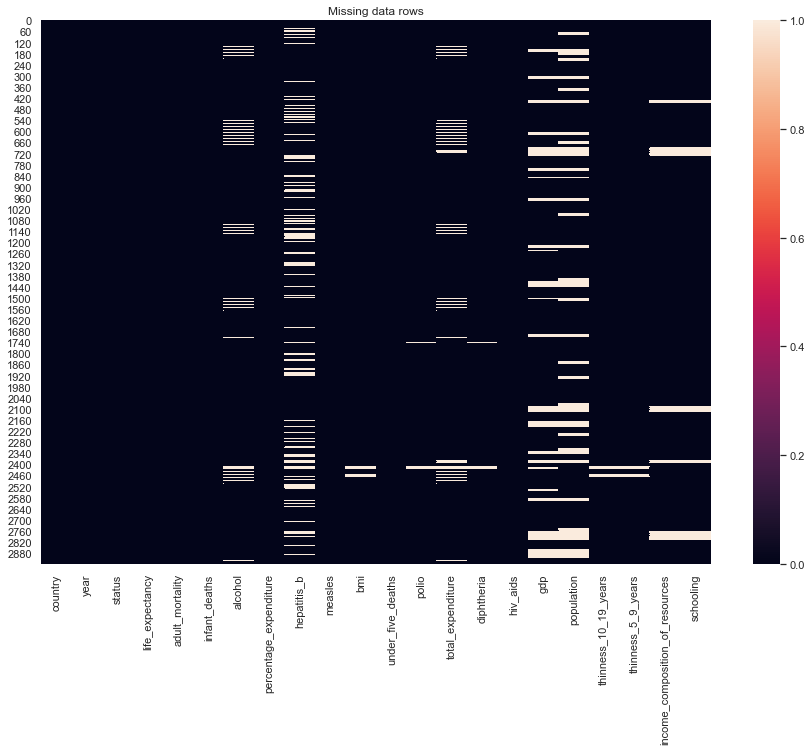

In [446]:
plt.figure(figsize = (15,10))
sns.heatmap(df_clean.isnull())
plt.title('Missing data rows');

In [447]:
print(cleaned_nulls,'\n\n','cleaned null cells:',cleaned_nulls.sum())

country                              0
year                                 0
status                               0
life_expectancy                     10
adult_mortality                     10
infant_deaths                        0
alcohol                            179
percentage_expenditure               0
hepatitis_b                        355
measles                              0
bmi                                  6
under_five_deaths                    0
polio                               13
total_expenditure                  188
diphtheria                          13
hiv_aids                             0
gdp                                 93
population                         101
thinness_10_19_years                 6
thinness_5_9_years                   6
income_composition_of_resources     29
schooling                           25
dtype: int64 

 cleaned null cells: 1034


- Going to drop the remaining n/a rows.
- The cleaning added just over 1000 additional cells to the dataset ~ 9%.

In [448]:
#drop remaining rows
df_clean_1.dropna(inplace = True, axis = 0)
df_clean.dropna(inplace = True, axis = 0)

### Modelling

#### Question
- Which are the most important factors for predicting life expectancy?

In [449]:
X_vars = ['alcohol','percentage_expenditure','hepatitis_b','measles','bmi','polio','total_expenditure','diphtheria',
    'hiv_aids','gdp','population','thinness_10_19_years','thinness_5_9_years','schooling','under_five_deaths']
X = df_clean[X_vars]
pca = PCA()
pca.fit(X)
pd.DataFrame(pca.explained_variance_ratio_, columns = ['explained_variance'])

explained_variance
0              1.00000
1              0.00000
2              0.00000
3              0.00000
4              0.00000
5              0.00000
6              0.00000
7              0.00000
8              0.00000
9              0.00000
10             0.00000
11             0.00000
12             0.00000
13             0.00000
14             0.00000

- One variable may be explaining all of the variance.

In [450]:
def linear_model(X,y, cv= 10, normalize = True, test_size=0.3, rand_state=42,print_ = True):
    """
    This function takes in variable columns and a target column and does the following:
    - splits the data into training and test sets
    - fits a linear model, after normalizing the features
    - calculates the model R-squared after performing cross validation
    - returns the model coefficients
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, random_state=rand_state)
    lm = LinearRegression(normalize=normalize)
    lm.fit(X_train,y_train)
    preds_lm = lm.predict(X_test)
    scores = cross_val_score(lm, X, y, cv = cv)
    
    feature_importance = pd.DataFrame(X.columns,columns = ['x_vars'])
    feature_importance['coeffs'] = lm.coef_
    feature_importance['abs_coeffs'] = abs(feature_importance.coeffs)
    
    feature_importance = feature_importance.sort_values(by='abs_coeffs',ascending = False)
    if print_:
        print(f'r-score: {scores.mean()}')
    
    return lm, scores, feature_importance

In [451]:
X_vars = ['alcohol','percentage_expenditure','hepatitis_b','measles','bmi','polio','total_expenditure','diphtheria',
    'hiv_aids','gdp','population','thinness_10_19_years','thinness_5_9_years','schooling','under_five_deaths']
X = df_clean[X_vars]
y = df_clean['life_expectancy']

lm_1,lm_1_scores, lm_1_coeffs = linear_model(X,y)

r-score: 0.6917662958154992


In [452]:
X_vars = ['alcohol','percentage_expenditure','hepatitis_b','measles','bmi','polio','total_expenditure','diphtheria',
    'hiv_aids','gdp','population','thinness_10_19_years','thinness_5_9_years','schooling','under_five_deaths']
X = df_clean_1[X_vars]
y = df_clean_1['life_expectancy']

lm_2,lm_2_scores, lm_2_coeffs = linear_model(X,y)

r-score: 0.7020604602468384


- Imputation led to slight increase in r-squared.

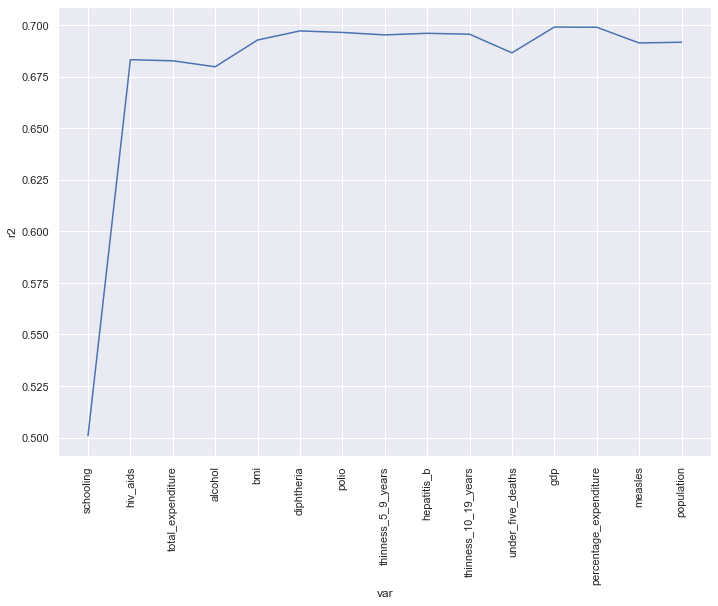

In [453]:
X_vars = []
y = df_clean.life_expectancy
scores = []
for var in lm_2_coeffs.x_vars:
    X_vars.append(var)
    X = df_clean[X_vars]
    lm,lm_scores, lm_coeffs = linear_model(X,y,print_=False)
    scores.append([var,lm_scores.mean()])

scores = pd.DataFrame(scores,columns = ['var','r2'])

sns.lineplot(data=scores,x='var',y='r2')
plt.xticks(rotation =90);

- The main factors driving the regression are schooling and hiv_aids

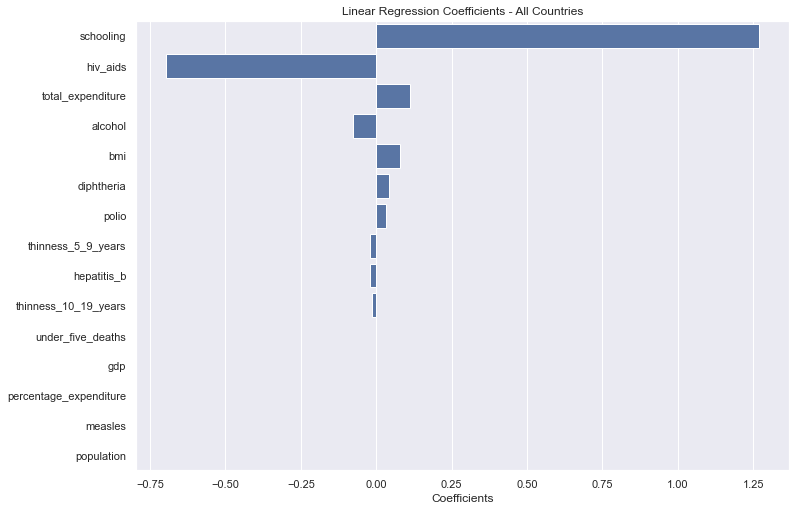

In [454]:
sns.barplot(y = 'x_vars',x = 'coeffs', data = lm_2_coeffs,color=base_colour)
plt.ylabel('')
plt.xlabel('Coefficients')
plt.title('Linear Regression Coefficients - All Countries');

- Higher schooling is a big predictor on a countries life expectancy.
- It is unclear whether this is a causal effect, or the impact of a different variable e.g. higher gdp
- The level of HIV/AIDS is an important predictor of life expectancy.


- Population, gdp, percentage expenditure, infant mortality (under five deaths) and measles do not appear to be good predictors of life expectancy.

In [455]:
mask = df_clean_1.status == 'Developed'
X_vars = ['alcohol','percentage_expenditure','hepatitis_b','measles','bmi','polio','total_expenditure','diphtheria',
    'hiv_aids','gdp','population','thinness_10_19_years','thinness_5_9_years','schooling','under_five_deaths']
X = df_clean_1[mask][X_vars]
y = df_clean_1[mask]['life_expectancy']

lm_3,lm_3_scores, lm_3_coeffs = linear_model(X,y)

r-score: -0.006495886283258434


- The regression model performs very badly on the developed country data.

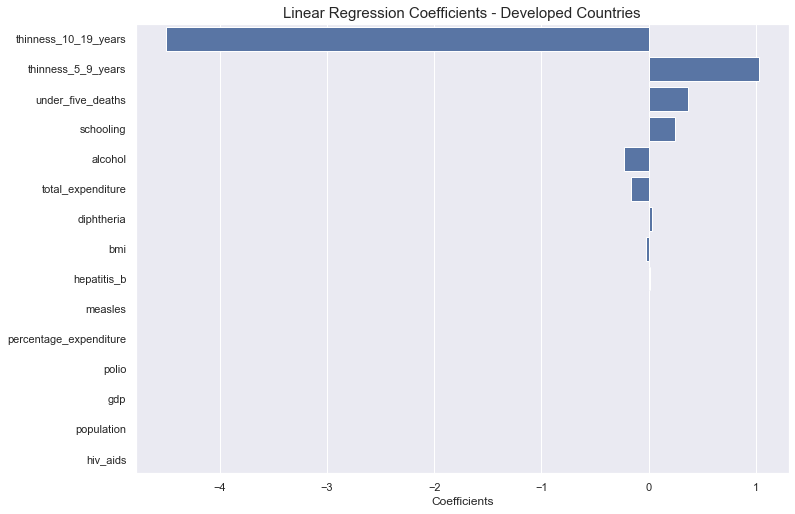

In [534]:
sns.barplot(y = 'x_vars',x = 'coeffs', data = lm_3_coeffs,color=base_colour)
plt.ylabel('')
plt.xlabel('Coefficients')
plt.title('Linear Regression Coefficients - Developed Countries', size = 15);

- Youth thinness is the most important factor in predicting life expectancy in developed countries based on the fit regression model.
- Given how badly the model fit to the data, it is tough to assign any credibility to the coefficients.

In [457]:
mask = df_clean_1.status == 'Developing'
X_vars = ['alcohol','percentage_expenditure','hepatitis_b','measles','bmi','polio','total_expenditure','diphtheria',
    'hiv_aids','gdp','population','thinness_10_19_years','thinness_5_9_years','schooling','under_five_deaths']
X = df_clean_1[mask][X_vars]
y = df_clean_1[mask]['life_expectancy']

lm_4,lm_4_scores, lm_4_coeffs = linear_model(X,y)

r-score: 0.6117913796674413


- Much higher r-squared for developing countries.

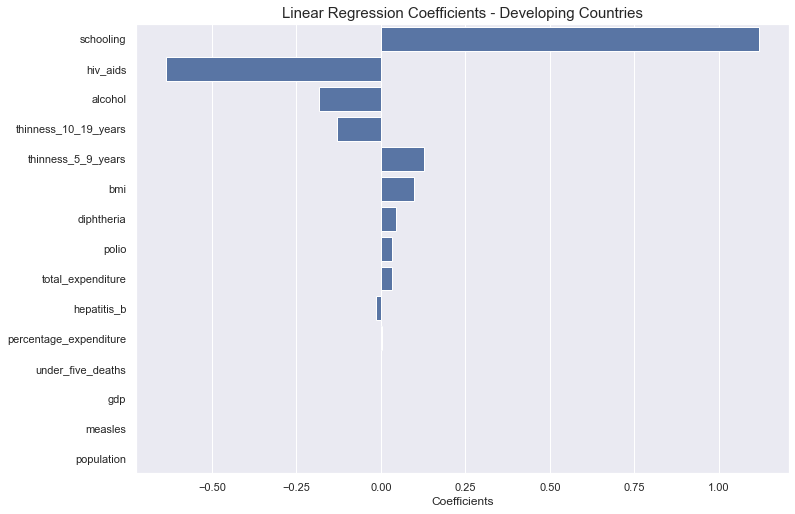

In [533]:
sns.barplot(y = 'x_vars',x = 'coeffs', data = lm_4_coeffs,color=base_colour)
plt.ylabel('')
plt.xlabel('Coefficients')
plt.title('Linear Regression Coefficients - Developing Countries', size = 15);

- Schooling and HIV/AIDS prevalence are the two most important factors in predicting life expectancy in developing countries, based on the fit regression model.